In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
donors_csv = f"./output/donors_with_recip_pacs_all_years.csv"

In [3]:
all_donors = pd.read_csv(donors_csv)
all_donors.head(10)

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,affiliate,pac,recip_id_pac,recipcode_pac,cand_id,party_pac,recip_is_pac,dem_ratio,level,cycle
0,U00000037041,N00029349,"BLOOMBERG, MICHAEL R",michael r bloomberg,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
1,U00000036521,N00044966,"STEYER, TOM",tom steyer,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
2,,N00001669,"INFORMATION REQUESTED, INFORMATION",information information requested,Y4000,,NaN,NaN,NEW YORK,CA,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
3,,C00484642,MAJORITY FORWARD,majority forward majority forward,Z9600,,NaN,NaN,WASHINGTON,DC,...,Senate Majority PAC,Senate Majority PAC,C00484642,OI,NaN,,True,1.0,Unknown,2020
4,,C00618371,WINRED,winred winred,Z9600,,NaN,NaN,ARLINGTON,VA,...,NaN,Trump Make America Great Again Cmte,C00618371,RP,NaN,R,True,0.0,Unknown,2020
5,,C00571703,CHEVRON CORPORATION,koch industries inc koch industries inc,Y4000,,NaN,NaN,WASHINGTON,TX,...,Senate Leadership Fund,Senate Leadership Fund,C00571703,OI,NaN,,True,0.0,Unknown,2020
6,,C00495028,CHC BOLD PAC,chc bold pac chc bold pac,Z9600,,NaN,NaN,WASHINGTON,DC,...,House Majority PAC,House Majority PAC,C00495028,PI,NaN,NaN,True,NaN,Unknown,2020
7,,C00693382,FUND FOR POLICY REFORM,fund for policy reform fund for policy reform,J1200,,NaN,NaN,WILMINGTON,DE,...,NaN,Democracy PAC ...,C00693382,OI,NaN,NaN,True,NaN,Unknown,2020
8,,C00669259,FUTURE FORWARD USA ACTION,future forward usa action future forward usa a...,J1200,,NaN,NaN,WASHINGTON,DC,...,NaN,Future Forward USA,C00669259,PI,NaN,,True,1.0,Unknown,2020
9,,C00504530,AMERICAN ACTION NETWORK,american action network american action network,Z9600,,NaN,NaN,WASHINGTON,DC,...,Congressional Leadership Fund,Congressional Leadership Fund,C00504530,OI,NaN,NaN,True,NaN,Unknown,2020


In [ ]:
def identify_top_donors(group):
    top_donors = (group.groupby('contrib_id')['total_donated']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10000)
                 .index)
    
    group = group.copy()
    group.loc[:, 'donor_type'] = group['contrib_id'].isin(top_donors).map({
        True: 'Top 10,000 Donors',
        False: 'Other Donors'
    })
    return group

temp = (all_donors.groupby('cycle', group_keys=False)
              .apply(identify_top_donors)
              .reset_index(drop=True))
cycle_donations = (temp.groupby(['cycle', 'donor_type'])['total_donated']
                  .sum()
                  .unstack())
cycle_percentages = cycle_donations.div(cycle_donations.sum(axis=1), axis=0) * 100

MemoryError: Unable to allocate 7.52 GiB for an array with shape (31, 32549402) and data type object

<Figure size 1400x400 with 0 Axes>

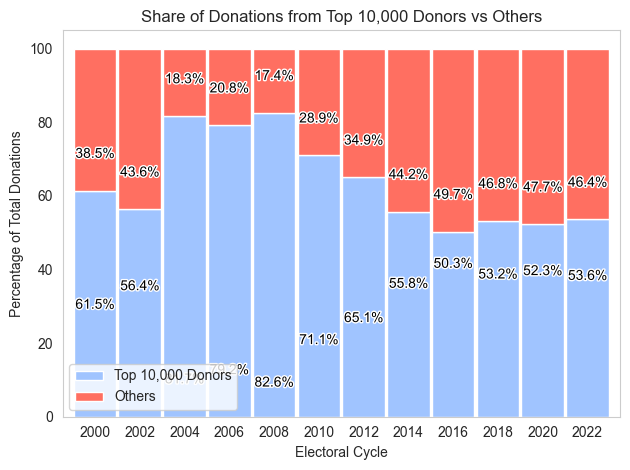

In [ ]:
plt.figure(figsize=(14, 4))
sns.set_style("whitegrid")

cycle_percentages.plot(kind='bar', stacked=True, color=['#A0C4FF', '#FF6F61'], width=0.95)

plt.title('Share of Donations from Top 10,000 Donors vs Others')
plt.ylabel('Percentage of Total Donations')
plt.xlabel('Electoral Cycle')
plt.xticks(rotation=0)

for n, cycle in enumerate(cycle_percentages.index):
    top_pct = cycle_percentages.loc[cycle, 'top_donor']
    other_pct = cycle_percentages.loc[cycle, 'other_donor']

    plt.text(n, other_pct + 10, f'{top_pct:.1f}%', ha='center', va='center', fontsize=10, color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
    plt.text(n, top_pct - 10, f'{other_pct:.1f}%', ha='center', va='bottom', fontsize=10, color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])

plt.grid(False)
plt.legend(['Top 10,000 Donors', 'Others'], loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
cycle_percentages

donor_type,other_donor,top_donor
cycle,,
2000,61.460137,38.539863
2002,56.410801,43.589199
2004,81.733302,18.266698
2006,79.230674,20.769326
2008,82.618465,17.381535
2010,71.059823,28.940177
2012,65.075850,34.924150
2014,55.764364,44.235636
2016,50.330585,49.669415


In [ ]:
cycle_donations

donor_type,other_donor,top_donor
cycle,,
2000,1.135718e+09,7.121755e+08
2002,8.753118e+08,6.763623e+08
2004,1.855189e+09,4.146190e+08
2006,1.323453e+09,3.469266e+08
2008,2.794978e+09,5.880164e+08
2010,1.439983e+09,5.864548e+08
2012,3.173984e+09,1.703377e+09
2014,1.532654e+09,1.215793e+09
2016,3.397436e+09,3.352805e+09


In [ ]:
cycle_counts

donor_type,other_donor,top_donor
cycle,,
2000,776562,4171
2002,650628,4199
2004,1123641,6088
2006,773202,6481
2008,1344731,7734
2010,812281,7666
2012,1268410,8204
2014,733185,7938
2016,2427625,8515


In [4]:
agg_all = all_donors.groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_all['group'] = 'All Donors'
agg_indian = all_donors[all_donors['ethnic'] == 'ind'].groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_indian['group'] = 'Indian-American Donors'

combined = pd.concat([agg_all, agg_indian])

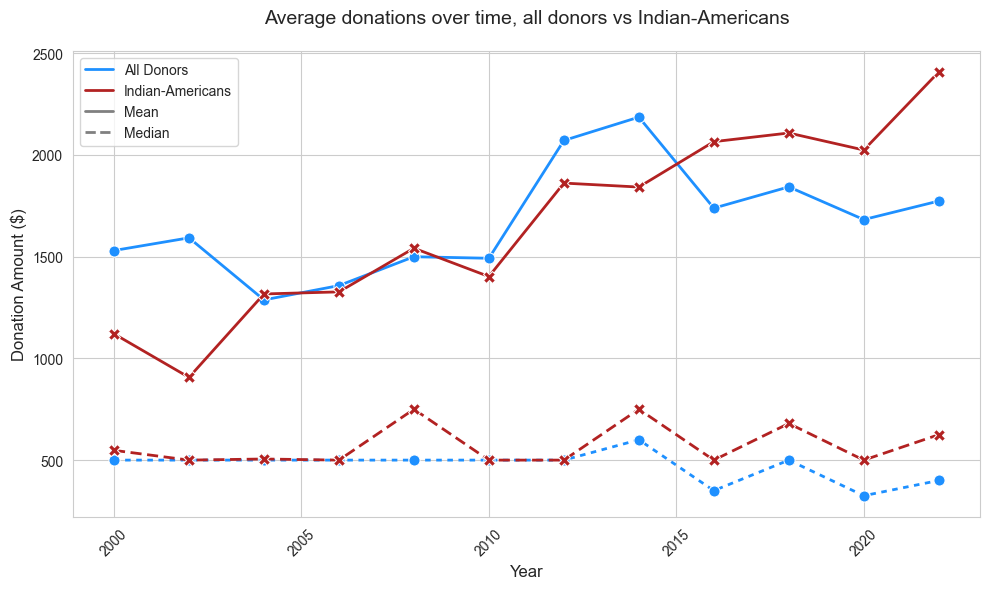

In [5]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=combined, x='cycle', y='mean', hue='group',
    style='group', markers=True, dashes=False,
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='o', markersize=8
)
sns.lineplot(
    data=combined, x='cycle', y='median', hue='group',
    style='group', markers=True, dashes=[(2,2), (4,2)],
    palette=['dodgerblue', 'firebrick'],
    linewidth=2, marker='s', markersize=8,
    legend=False
)

plt.title('Average donations over time, all donors vs Indian-Americans', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Donation Amount ($)', fontsize=12)
plt.xticks(rotation=45)

legend_elements = [
    Line2D([0], [0], color='dodgerblue', lw=2, label='All Donors'),
    Line2D([0], [0], color='firebrick', lw=2, label='Indian-Americans'),
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Mean'),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Median')
]
plt.legend(handles=legend_elements, loc='upper left', frameon=True)

plt.tight_layout()
plt.show()

In [6]:
sector_counts_all = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_counts_indian = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])][all_donors["ethnic"] == "ind"]
    .groupby(['cycle', 'sector'])
    .size()
    .unstack(fill_value=0)
)

sector_pct_all = sector_counts_all.div(sector_counts_all.sum(axis=1), axis=0) * 100
sector_pct_indian = sector_counts_indian.div(sector_counts_indian.sum(axis=1), axis=0) * 100

In [7]:
sector_sums_all = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])]
    .groupby(['cycle', 'sector'])
    ["total_donated"].sum()
    .unstack(fill_value=0)
)

sector_sums_indian = (
    all_donors[~all_donors["sector"].isin(["Unknown", "Party", "Ideology/Single Issue"])][all_donors["ethnic"] == "ind"]
    .groupby(['cycle', 'sector'])
    ["total_donated"].sum()
    .unstack(fill_value=0)
)

sector_pct_all_sum = sector_sums_all.div(sector_sums_all.sum(axis=1), axis=0) * 100
sector_pct_indian_sum = sector_sums_indian.div(sector_sums_indian.sum(axis=1), axis=0) * 100

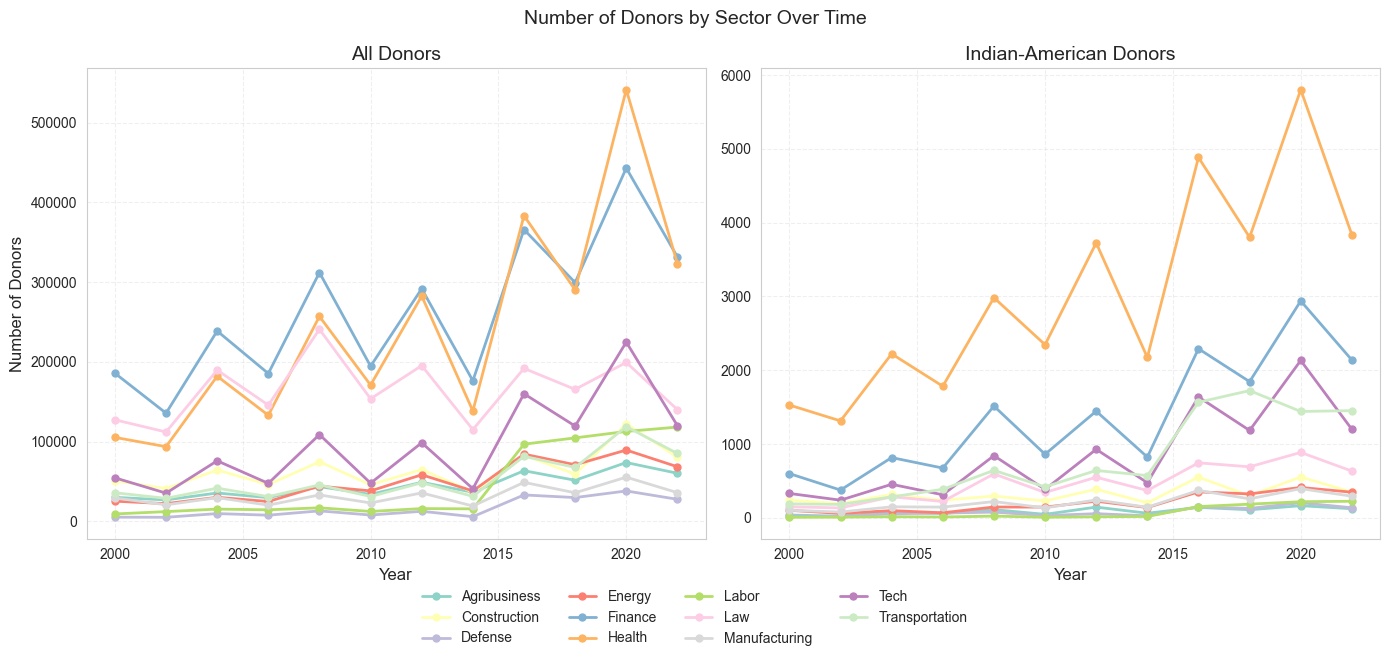

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
colors = sns.color_palette("Set3", n_colors=len(sector_counts_all.columns))

for i, sector in enumerate(sector_counts_all.columns):
    ax1.plot(
        sector_counts_all.index,
        sector_counts_all[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax1.set_title("All Donors", fontsize=14)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

for i, sector in enumerate(sector_counts_indian.columns):
    ax2.plot(
        sector_counts_indian.index,
        sector_counts_indian[sector],
        label=sector,
        color=colors[i],
        marker='o',
        markersize=5,
        linewidth=2
    )

ax2.set_title("Indian-American Donors", fontsize=14)
ax2.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Donors", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=10,
    frameon=False
)

plt.suptitle("Number of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
sector_counts_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,29939,50638,5050,25113,185709,105174,9077,127257,29154,54446,35691
2002,26697,41009,4908,22011,135562,93517,12028,111950,20538,35192,28670
2004,35383,64206,9544,30005,238673,181909,15189,189639,29549,75777,41434
2006,29580,45957,7538,24683,185325,132936,14268,145660,20165,47517,30855
2008,43369,74526,12946,44024,312051,256997,16800,240791,32964,108686,45445
2010,33691,45700,7725,38005,194489,170803,12243,153603,22939,47726,30988
2012,48858,64792,12444,58254,291725,282603,15832,195241,35484,98438,48249
2014,36328,36438,5659,37982,176199,138297,15500,114942,19069,40769,31194
2016,63335,82836,32944,84134,365945,383444,96630,191744,48741,159916,81422


In [10]:
sector_counts_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,38,240,18,101,599,1528,7,149,102,330,189
2002,22,192,20,60,376,1313,9,134,78,239,181
2004,76,316,55,97,816,2222,15,285,149,454,283
2006,58,238,64,68,674,1783,11,221,145,312,386
2008,110,295,77,146,1514,2983,23,595,220,842,643
2010,47,228,30,145,861,2346,8,343,134,385,419
2012,145,387,56,225,1445,3725,14,550,242,928,642
2014,62,203,27,139,823,2174,18,370,143,476,572
2016,141,551,149,351,2291,4884,152,745,371,1638,1566


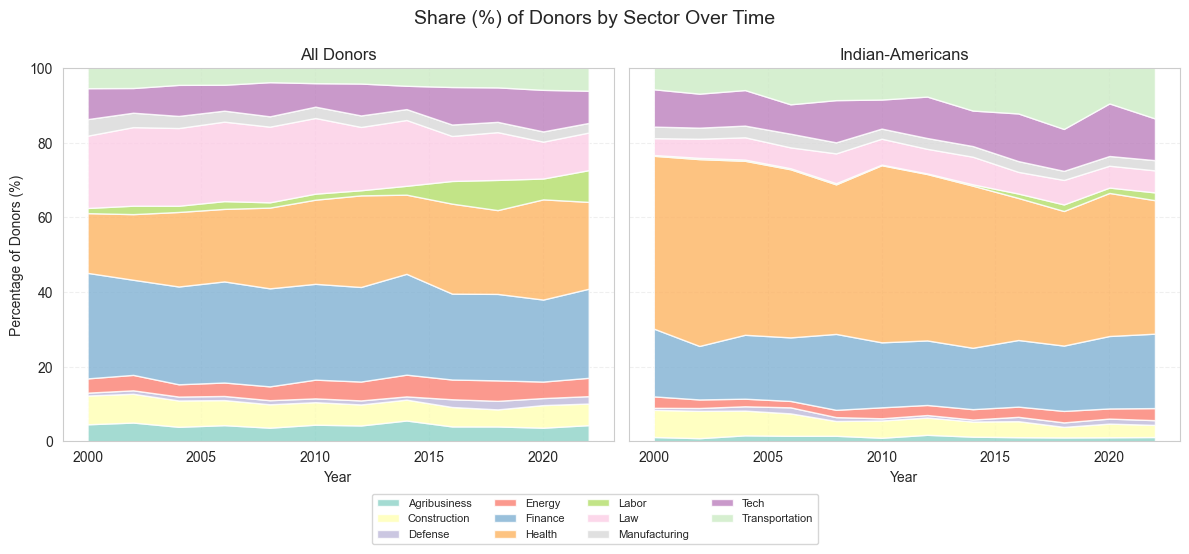

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = sns.color_palette("Set3", n_colors=len(sector_pct_all.columns))

ax1.stackplot(
    sector_pct_all.index,
    sector_pct_all.T,
    labels=sector_pct_all.columns,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("All Donors", fontsize=12)
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sector_pct_indian.index,
    sector_pct_indian.T,
    labels=sector_pct_indian.columns,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_xlabel("Year")
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Donors by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
sector_pct_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,4.555206,7.704550,0.768355,3.820932,28.255544,16.002179,1.381062,19.362098,4.435769,8.283935,5.430370
2002,5.017460,7.707271,0.922414,4.136768,25.477652,17.575674,2.260554,21.039990,3.859931,6.614018,5.388267
2004,3.882661,7.045477,1.047286,3.292520,26.190157,19.961308,1.666725,20.809540,3.242482,8.315191,4.546652
2006,4.321503,6.714109,1.101268,3.606074,27.075140,19.421345,2.084490,21.280264,2.946015,6.942018,4.507775
2008,3.648749,6.270071,1.089181,3.703856,26.253682,21.621842,1.413429,20.258388,2.773349,9.144043,3.823409
2010,4.445239,6.029724,1.019248,5.014434,25.661159,22.535994,1.615359,20.266601,3.026605,6.297037,4.088601
2012,4.241440,5.624696,1.080283,5.057122,25.325109,24.533214,1.374401,16.949180,3.080422,8.545559,4.188572
2014,5.568559,5.585421,0.867443,5.822094,27.008769,21.198939,2.375927,17.618953,2.923003,6.249301,4.781591
2016,3.980602,5.206239,2.070529,5.287818,22.999627,24.099439,6.073191,12.051102,3.063370,10.050714,5.117369


In [13]:
sector_pct_indian

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,1.151166,7.270524,0.545289,3.059679,18.146016,46.289003,0.212057,4.513784,3.089973,9.996971,5.725538
2002,0.838415,7.317073,0.762195,2.286585,14.329268,50.038110,0.342988,5.106707,2.972561,9.108232,6.897866
2004,1.593960,6.627517,1.153523,2.034396,17.114094,46.602349,0.314597,5.977349,3.125000,9.521812,5.935403
2006,1.464646,6.010101,1.616162,1.717172,17.020202,45.025253,0.277778,5.580808,3.661616,7.878788,9.747475
2008,1.476907,3.960795,1.033835,1.960258,20.327605,40.051020,0.308808,7.988722,2.953813,11.305048,8.633190
2010,0.950263,4.609786,0.606551,2.931662,17.408006,47.432268,0.161747,6.934897,2.709260,7.784068,8.471492
2012,1.734657,4.629740,0.669937,2.691710,17.286757,44.562747,0.167484,6.579734,2.895083,11.101806,7.680345
2014,1.238266,4.054324,0.539245,2.776113,16.436988,43.419213,0.359497,7.389654,2.856002,9.506691,11.424006
2016,1.098216,4.291611,1.160527,2.733858,17.844069,38.040346,1.183893,5.802633,2.889633,12.758003,12.197212


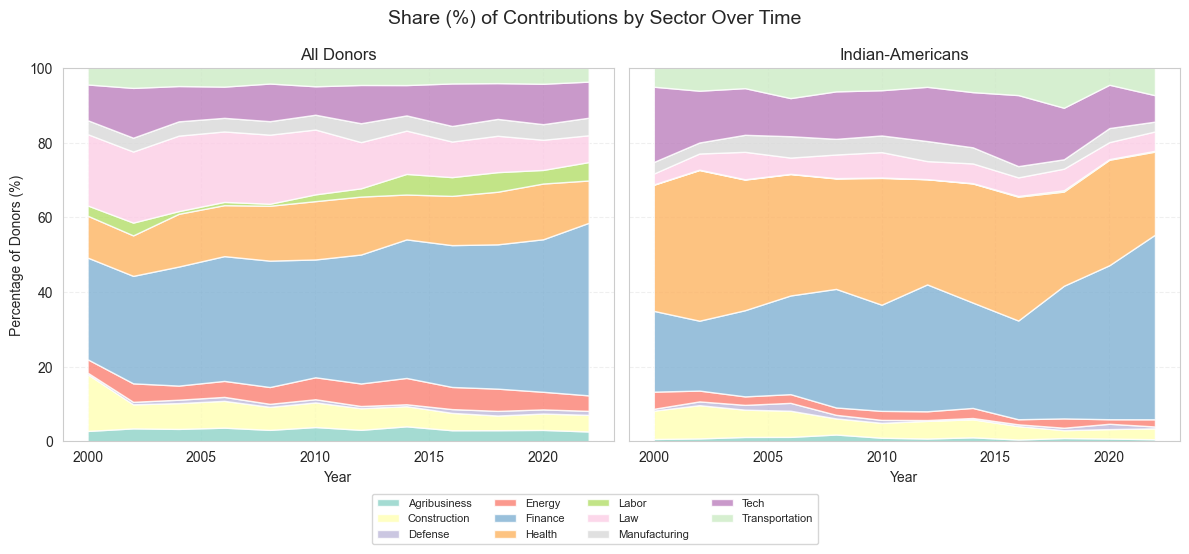

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
colors = sns.color_palette("Set3", n_colors=len(sector_pct_all_sum.columns))

ax1.stackplot(
    sector_pct_all_sum.index,
    sector_pct_all_sum.T,
    labels=sector_pct_all_sum.columns,
    colors=colors,
    alpha=0.8,
)
ax1.set_title("All Donors", fontsize=12)
ax1.set_xlabel("Year")
ax1.set_ylabel("Percentage of Donors (%)")
ax1.set_ylim(0, 100)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2.stackplot(
    sector_pct_indian_sum.index,
    sector_pct_indian_sum.T,
    labels=sector_pct_indian_sum.columns,
    colors=colors,
    alpha=0.8,
)
ax2.set_title("Indian-Americans", fontsize=12)
ax2.set_xlabel("Year")
ax2.grid(True, linestyle='--', alpha=0.3)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=8
)

plt.suptitle("Share (%) of Contributions by Sector Over Time", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
sector_pct_all_sum

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,2.767507,15.200684,0.413661,3.587076,27.236754,11.215131,2.742428,19.094413,3.736706,9.567767,4.437872
2002,3.460844,6.440632,0.669437,4.945753,28.784930,10.839783,3.425011,19.030969,3.709764,13.334990,5.357887
2004,3.313742,6.913867,0.907346,3.780862,31.883645,14.123322,0.725290,20.212079,3.828086,9.459276,4.852484
2006,3.649103,7.185046,1.055682,4.283263,33.417034,13.650672,0.873780,18.864474,3.643476,8.363459,5.014009
2008,3.058408,6.167004,0.806857,4.501893,33.845916,14.701343,0.532216,18.504104,3.612302,10.084200,4.185757
2010,3.819856,6.590553,0.852906,5.881427,31.551002,15.619684,1.817993,17.360577,3.964891,7.623093,4.918017
2012,3.069932,5.800401,0.578625,6.038013,34.532568,15.515772,2.216960,12.373034,5.052111,10.253472,4.569112
2014,4.009631,5.394514,0.516368,7.046666,37.109684,12.012849,5.519162,11.593774,4.071814,8.129366,4.596172
2016,2.960723,4.647877,1.014861,5.928030,37.983073,13.191103,5.021903,9.530659,4.169036,11.388535,4.164200


In [16]:
sector_pct_indian_sum

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Labor,Law,Manufacturing,Tech,Transportation
cycle,,,,,,,,,,,
2000,0.620584,7.590427,0.497498,4.587434,21.631782,33.773000,0.091242,2.918620,3.102416,20.147118,5.039879
2002,0.771596,8.905519,1.006865,2.898539,18.714402,40.344394,0.111217,4.322235,2.947204,13.869503,6.108525
2004,1.165252,7.305374,1.285017,2.270462,23.080723,34.979888,0.090200,7.346728,4.556965,12.499264,5.420128
2006,1.183228,6.999752,2.107091,2.335880,26.426770,32.513730,0.070029,4.340883,5.725177,10.209412,8.088047
2008,1.812980,4.315201,0.957743,1.972148,31.759969,29.578598,0.084255,6.323913,4.194271,12.718194,6.282726
2010,0.957902,3.985487,0.787597,2.418689,28.429793,33.953591,0.103922,6.808828,4.458860,12.120458,5.974873
2012,0.746305,4.720435,0.227061,2.345490,33.975363,28.171273,0.032264,4.822494,5.372140,14.520473,5.066701
2014,1.068313,4.824529,0.345029,2.697017,28.221404,31.894410,0.087995,5.274443,4.321915,14.777855,6.487091
2016,0.477504,3.599599,0.469532,1.360025,26.438602,33.162498,0.190631,4.978768,3.017248,19.023365,7.282228


In [ ]:
mean_all = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle", "sector"])["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle", "sector"])["dem_ratio"].mean().sort_values(ascending=False)
mean_all = mean_all.unstack(level='sector')
mean_ind = mean_ind.unstack(level='sector')

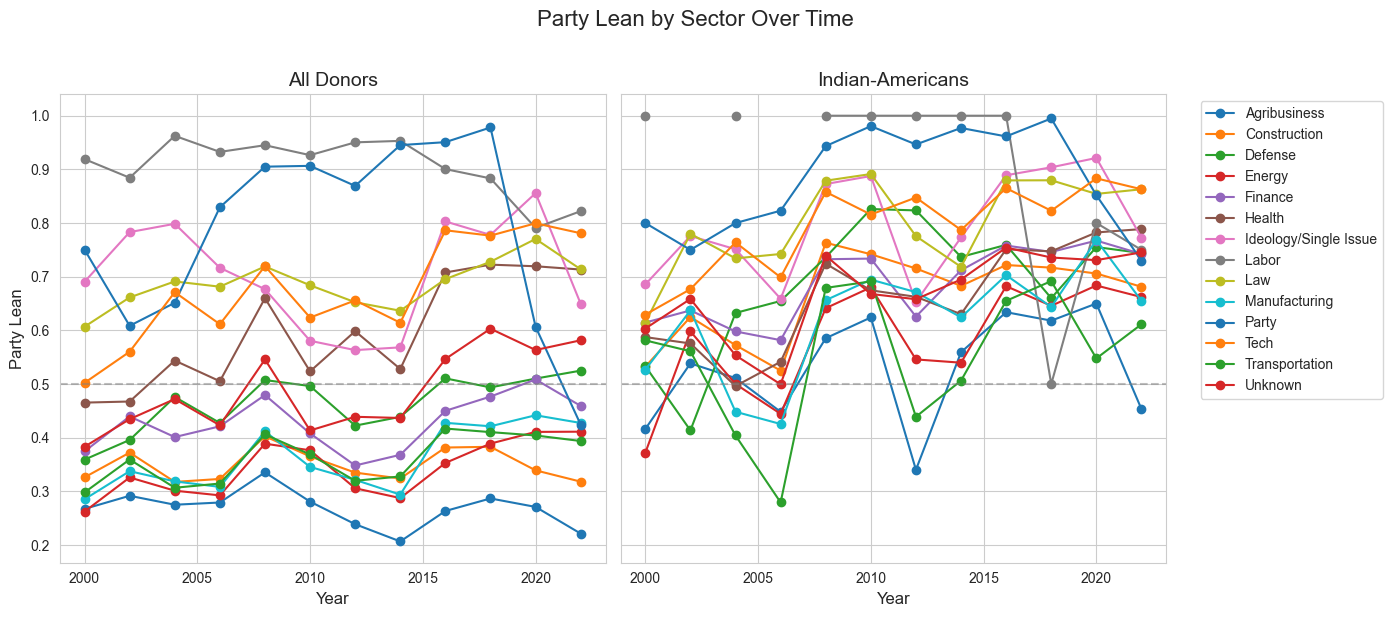

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in mean_all.columns:
    ax1.plot(
        mean_all.index,
        mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in mean_ind.columns:
    ax2.plot(
        mean_ind.index,
        mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.267316,0.326098,0.359120,0.262300,0.374497,0.465375,0.690557,0.919090,0.606807,0.285300,0.750420,0.502188,0.297993,0.383134
2002,0.291728,0.372199,0.395771,0.325875,0.439570,0.467410,0.783091,0.884434,0.661377,0.337569,0.608454,0.560163,0.359343,0.434498
2004,0.275064,0.317615,0.475845,0.301248,0.401163,0.543730,0.798594,0.962507,0.691146,0.318560,0.651382,0.671183,0.306730,0.471947
2006,0.279201,0.323120,0.427470,0.292525,0.421176,0.505205,0.716642,0.932556,0.681370,0.308302,0.829388,0.611473,0.314558,0.423063
2008,0.335351,0.402614,0.507415,0.388819,0.479447,0.659899,0.676727,0.945012,0.719034,0.411786,0.905035,0.719779,0.406104,0.545791
2010,0.280847,0.365162,0.496238,0.376539,0.407894,0.523569,0.580569,0.926508,0.684016,0.345512,0.906570,0.623825,0.368701,0.413478
2012,0.238802,0.334915,0.422433,0.305744,0.348197,0.598430,0.563202,0.950358,0.652383,0.321422,0.869165,0.655892,0.319707,0.438942
2014,0.206665,0.323948,0.438797,0.287493,0.368086,0.528000,0.568298,0.953109,0.636574,0.293903,0.945248,0.614196,0.327750,0.436743
2016,0.263377,0.381677,0.510529,0.352921,0.450046,0.707863,0.802999,0.900527,0.695425,0.427699,0.950711,0.786496,0.417042,0.546617


In [ ]:
mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.416149,0.532243,0.533333,0.371873,0.614564,0.587456,0.685532,1.00,0.614380,0.526679,0.800000,0.629376,0.581340,0.603409
2002,0.538462,0.624891,0.413636,0.598039,0.637151,0.575587,0.775865,NaN,0.779924,0.637118,0.750000,0.676722,0.561075,0.658518
2004,0.511111,0.572449,0.632456,0.500000,0.597997,0.496240,0.751159,1.00,0.734127,0.448306,0.800000,0.763917,0.404094,0.553458
2006,0.448214,0.524989,0.654762,0.444444,0.581754,0.541433,0.658914,NaN,0.742308,0.425488,0.823010,0.698813,0.279328,0.499505
2008,0.585366,0.763292,0.736144,0.641304,0.732536,0.724229,0.872656,1.00,0.878886,0.656235,0.943396,0.857982,0.679112,0.739088
2010,0.624000,0.741855,0.826087,0.680123,0.733739,0.674602,0.887588,1.00,0.891335,0.694553,0.980583,0.815844,0.691232,0.667833
2012,0.340202,0.715313,0.823529,0.545844,0.625625,0.662514,0.652736,1.00,0.775578,0.671204,0.946435,0.847527,0.438991,0.658029
2014,0.559250,0.682892,0.736842,0.539760,0.711980,0.630132,0.773208,1.00,0.718290,0.624225,0.977120,0.787012,0.506354,0.694726
2016,0.633880,0.721729,0.759334,0.682295,0.758058,0.751187,0.889046,1.00,0.879446,0.702880,0.961404,0.865021,0.655004,0.754254


In [ ]:
dollar_mean_all = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)
dollar_mean_ind = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)

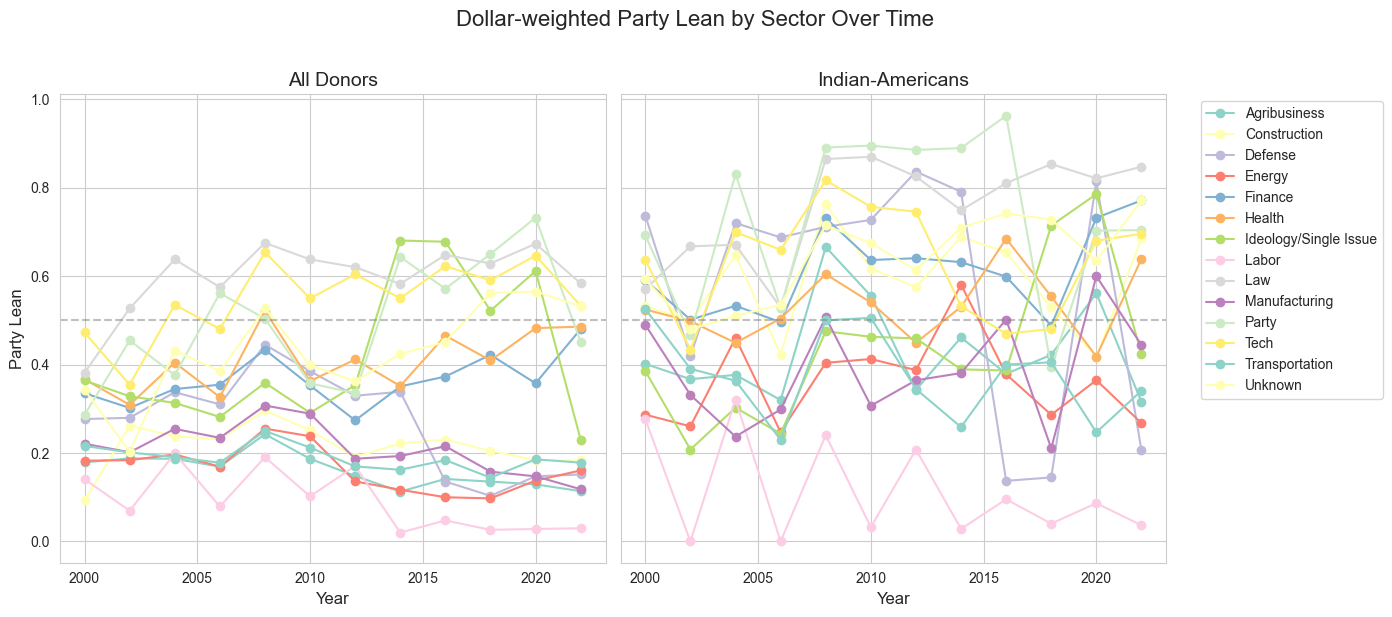

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in dollar_mean_all.columns:
    ax1.plot(
        dollar_mean_all.index,
        dollar_mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in dollar_mean_ind.columns:
    ax2.plot(
        dollar_mean_ind.index,
        dollar_mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Dollar-weighted Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
dollar_mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.178917,0.092835,0.276898,0.182672,0.335291,0.366939,0.364249,0.140773,0.381702,0.221068,0.286247,0.472823,0.216019,0.342847
2002,0.187897,0.261335,0.279675,0.183892,0.302100,0.309016,0.328384,0.069385,0.527044,0.201679,0.454719,0.354693,0.201366,0.202687
2004,0.186994,0.238496,0.337662,0.196818,0.344827,0.404486,0.313415,0.199051,0.638029,0.254729,0.376447,0.535230,0.190865,0.431579
2006,0.169091,0.230885,0.310045,0.169113,0.354560,0.326531,0.281676,0.079158,0.575190,0.234375,0.561649,0.480726,0.178019,0.385105
2008,0.242587,0.296258,0.445076,0.255284,0.433829,0.522184,0.358827,0.190558,0.675460,0.307516,0.504015,0.654353,0.250100,0.527434
2010,0.186936,0.251340,0.385185,0.238021,0.352836,0.362658,0.290902,0.102035,0.638098,0.289103,0.357502,0.549867,0.212274,0.398794
2012,0.148163,0.190648,0.329611,0.135813,0.273897,0.411621,0.353512,0.170618,0.620471,0.187033,0.335694,0.604354,0.169767,0.362628
2014,0.112777,0.221964,0.338601,0.116972,0.350634,0.351681,0.680792,0.019925,0.582687,0.193244,0.643504,0.550096,0.162137,0.424444
2016,0.141398,0.230612,0.135508,0.099931,0.373139,0.465692,0.678003,0.047544,0.648406,0.215446,0.571613,0.622913,0.184007,0.451217


In [ ]:
dollar_mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.401747,0.532400,0.737299,0.286772,0.591393,0.524596,0.385615,0.276778,0.571155,0.490063,0.692308,0.636775,0.525786,0.593787
2002,0.367031,0.498673,0.419952,0.260447,0.501657,0.498337,0.207972,0.000000,0.667654,0.331439,0.466667,0.434101,0.390546,0.480196
2004,0.376905,0.647590,0.720265,0.460535,0.533077,0.449272,0.302659,0.320718,0.671163,0.237161,0.831190,0.699772,0.363562,0.510615
2006,0.319842,0.422834,0.687806,0.247221,0.496077,0.504345,0.243905,0.000000,0.528917,0.298583,0.528421,0.659830,0.230017,0.535078
2008,0.666005,0.764289,0.711716,0.404089,0.731203,0.604599,0.475523,0.240298,0.865193,0.506898,0.891213,0.816974,0.500116,0.715016
2010,0.555635,0.617472,0.727508,0.412695,0.636719,0.540630,0.462980,0.032242,0.870284,0.306989,0.895579,0.757014,0.505897,0.674732
2012,0.342723,0.575544,0.836697,0.387596,0.640760,0.449766,0.459331,0.207994,0.825688,0.364569,0.885803,0.745926,0.344803,0.614157
2014,0.461601,0.689362,0.791100,0.580962,0.631871,0.530598,0.389300,0.028361,0.749268,0.380976,0.889966,0.532058,0.258603,0.709920
2016,0.379240,0.653809,0.137051,0.378197,0.599107,0.684996,0.386871,0.095334,0.810651,0.502095,0.963170,0.469834,0.400133,0.742139


In [ ]:
mean_all_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["dem_ratio"].mean()
mean_ind_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle"])["dem_ratio"].mean()

In [ ]:
dollar_mean_all_by_year = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_ind_by_year = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

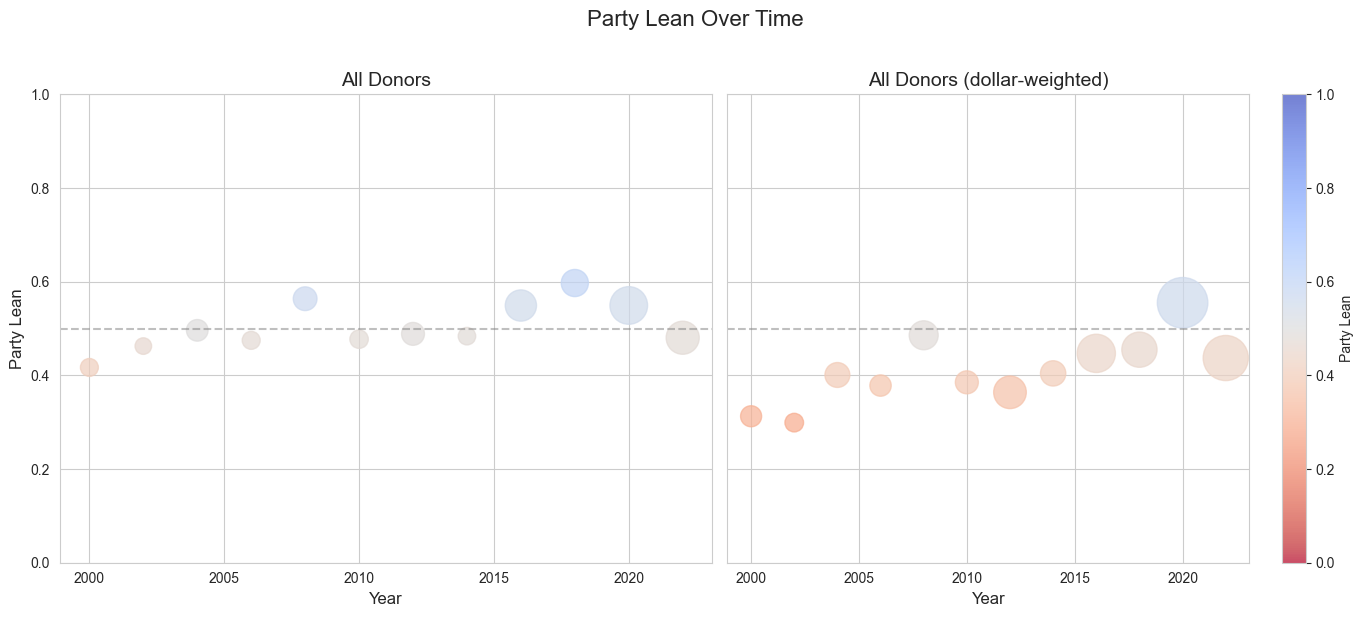

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all_by_year.index,
    mean_all_by_year,
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/5000,
    c=mean_all_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all_by_year.index,
    dollar_mean_all_by_year,
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

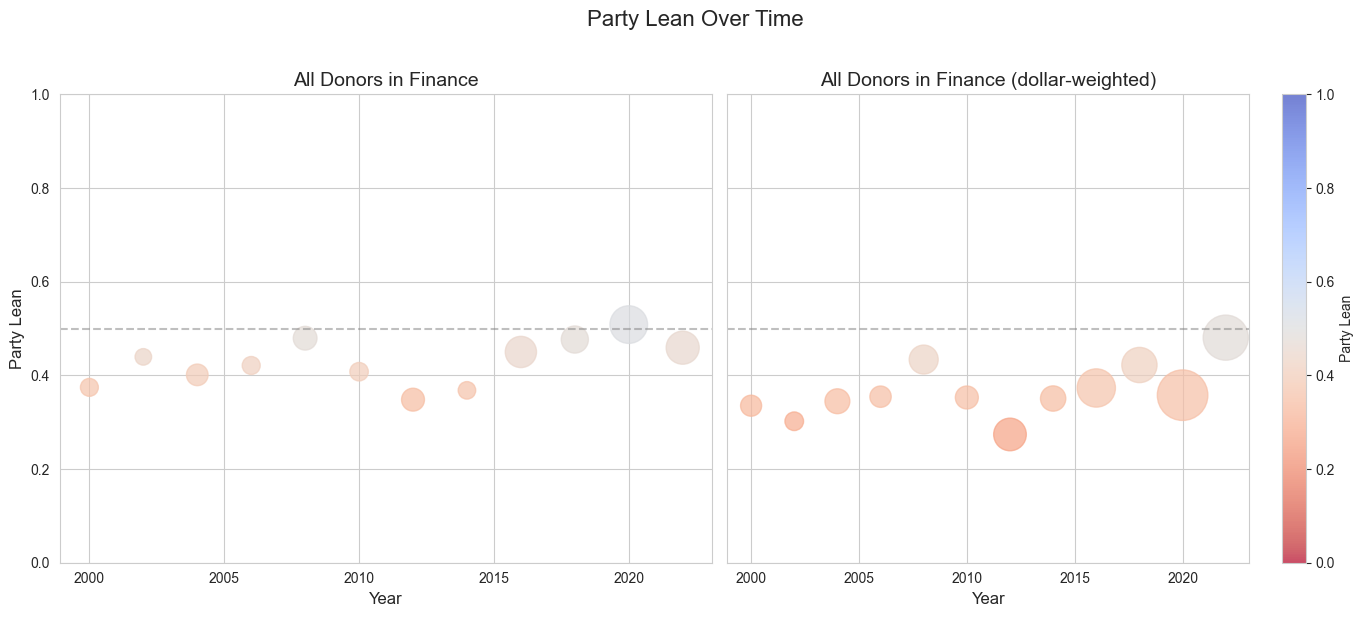

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all.index,
    mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/5000,
    c=mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Donors in Finance (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

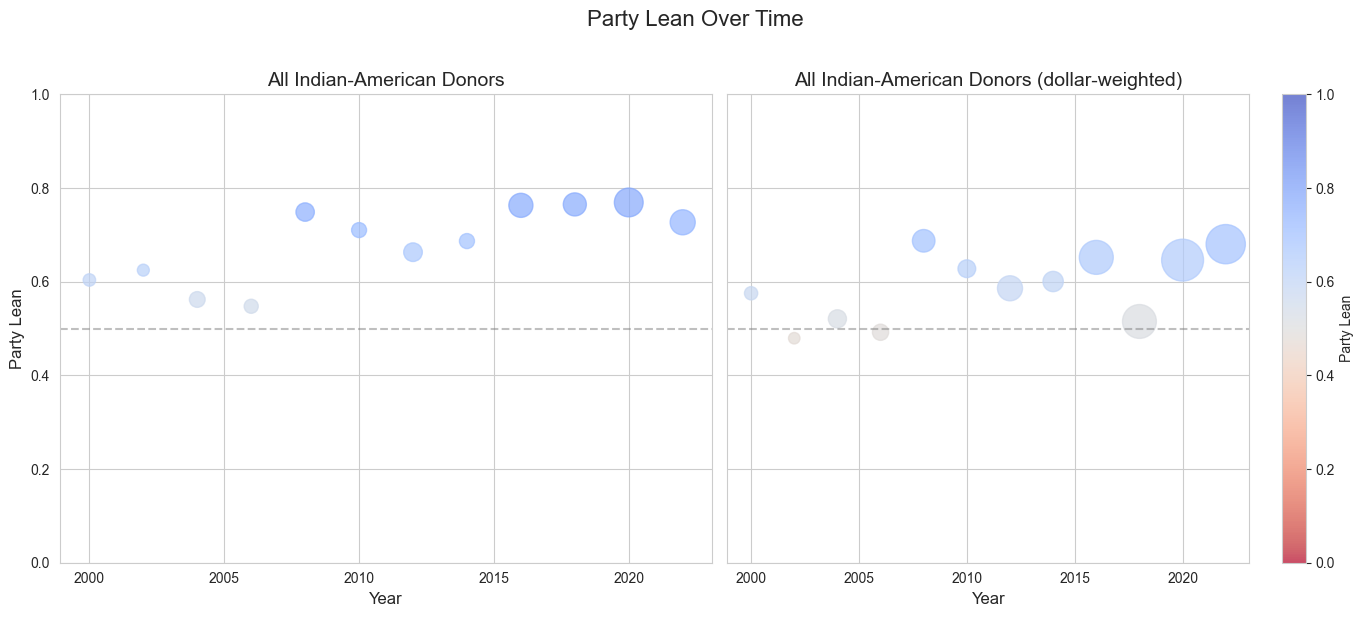

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind_by_year.index,
    mean_ind_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/50,
    c=mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind_by_year.index,
    dollar_mean_ind_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/50000,
    c=dollar_mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

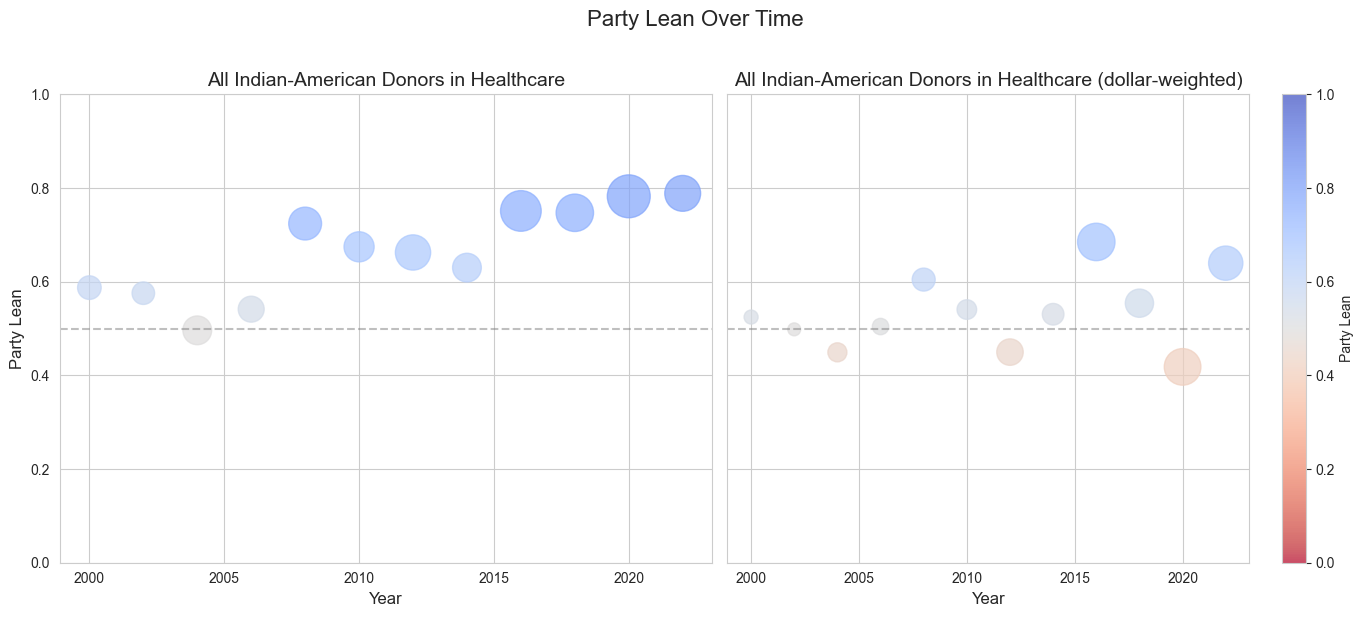

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Health"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/4,
    c=mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Healthcare', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Health"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/10000,
    c=dollar_mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Healthcare (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

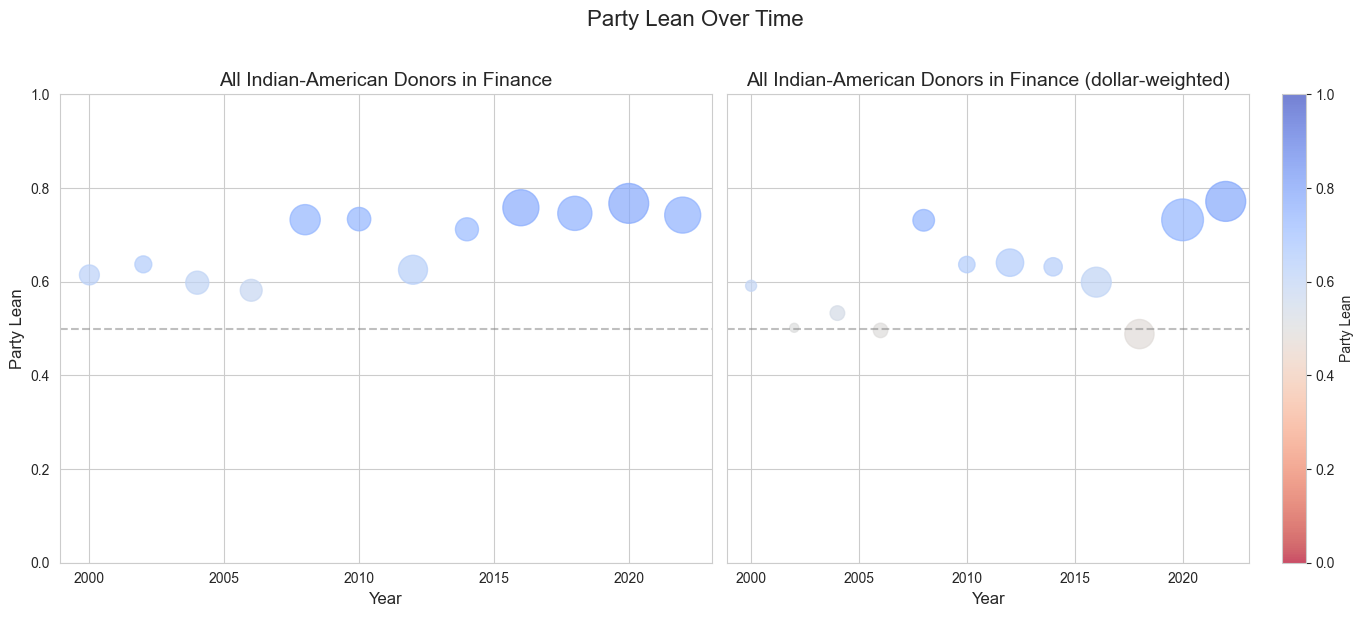

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Finance"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Finance")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/2,
    c=mean_ind["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Finance"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Finance")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/10000,
    c=dollar_mean_ind["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Finance (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

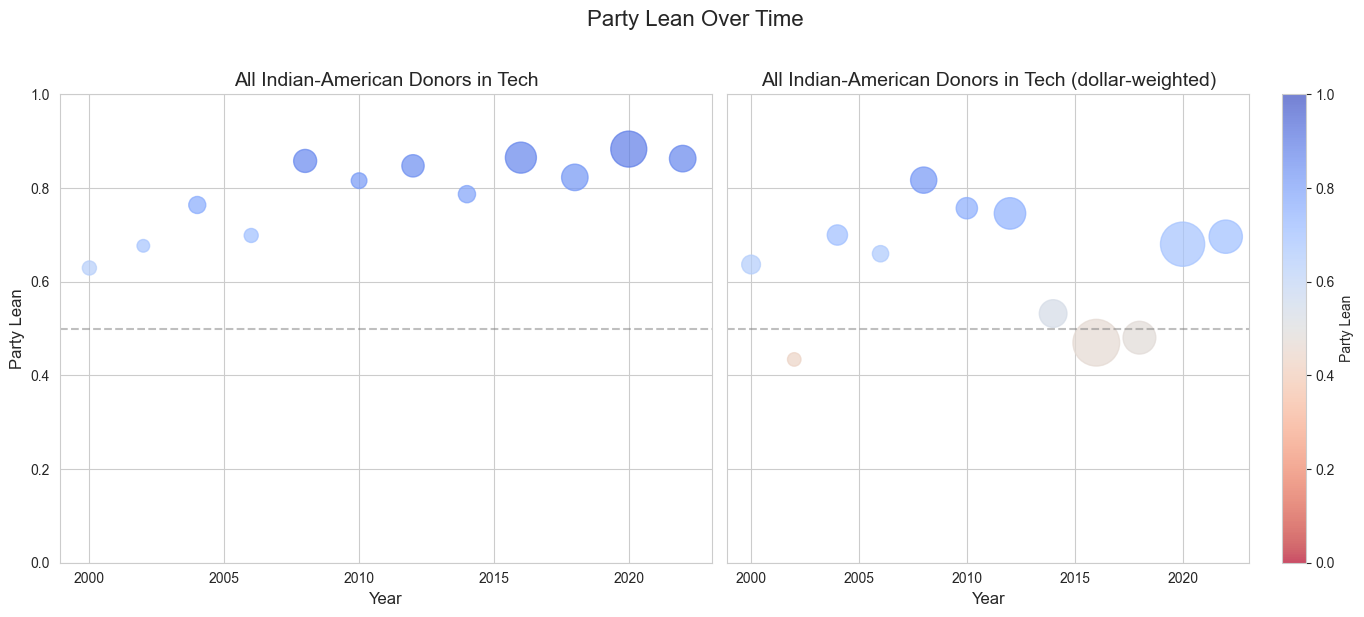

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Tech"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Tech")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/2,
    c=mean_ind["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Tech', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Tech"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Tech")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/3000,
    c=dollar_mean_ind["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Tech (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

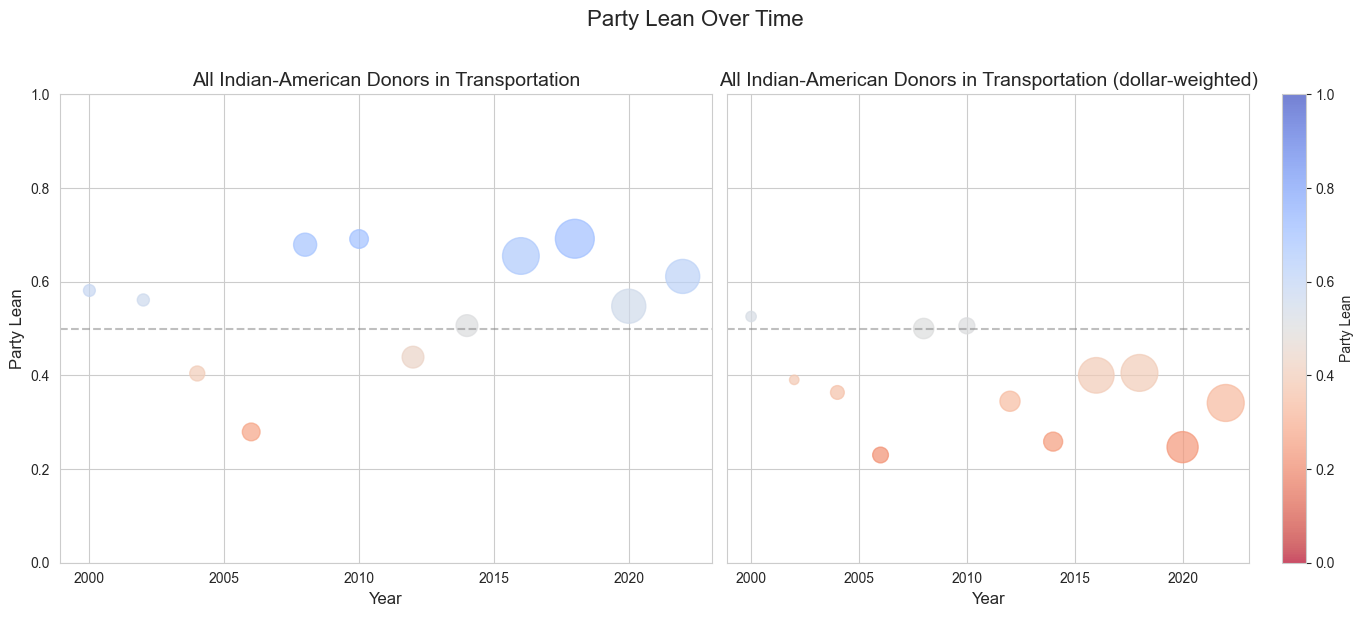

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Transportation"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Transportation")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/2,
    c=mean_ind["Transportation"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Transportation', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Transportation"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Transportation")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/3000,
    c=dollar_mean_ind["Transportation"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Transportation (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

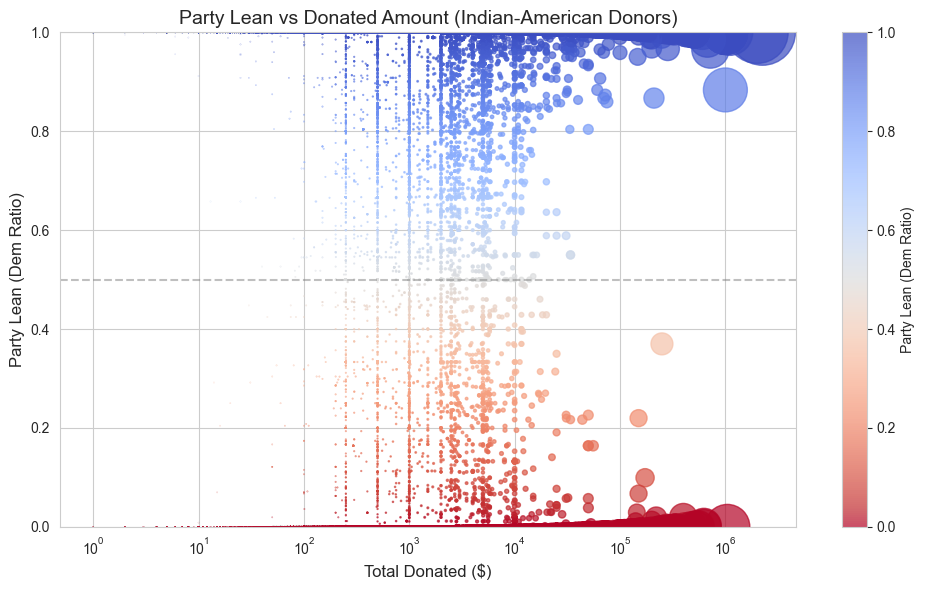

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("Set3")

norm = plt.Normalize(0, 1)

fig, ax = plt.subplots(figsize=(10, 6))

sc = ax.scatter(
    all_donors[all_donors["ethnic"] == "ind"]["total_donated"],
    all_donors[all_donors["ethnic"] == "ind"]["dem_ratio"],
    s=all_donors[all_donors["ethnic"] == "ind"]["total_donated"] / 1000,
    c=all_donors[all_donors["ethnic"] == "ind"]["dem_ratio"],
    cmap=plt.cm.coolwarm_r,
    norm=norm,
    alpha=0.7
)

ax.set_title('Party Lean vs Donated Amount (Indian-American Donors)', fontsize=14)
ax.set_xlabel('Total Donated ($)', fontsize=12)
ax.set_ylabel('Party Lean (Dem Ratio)', fontsize=12)
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='Party Lean (Dem Ratio)')

plt.tight_layout()
plt.show()

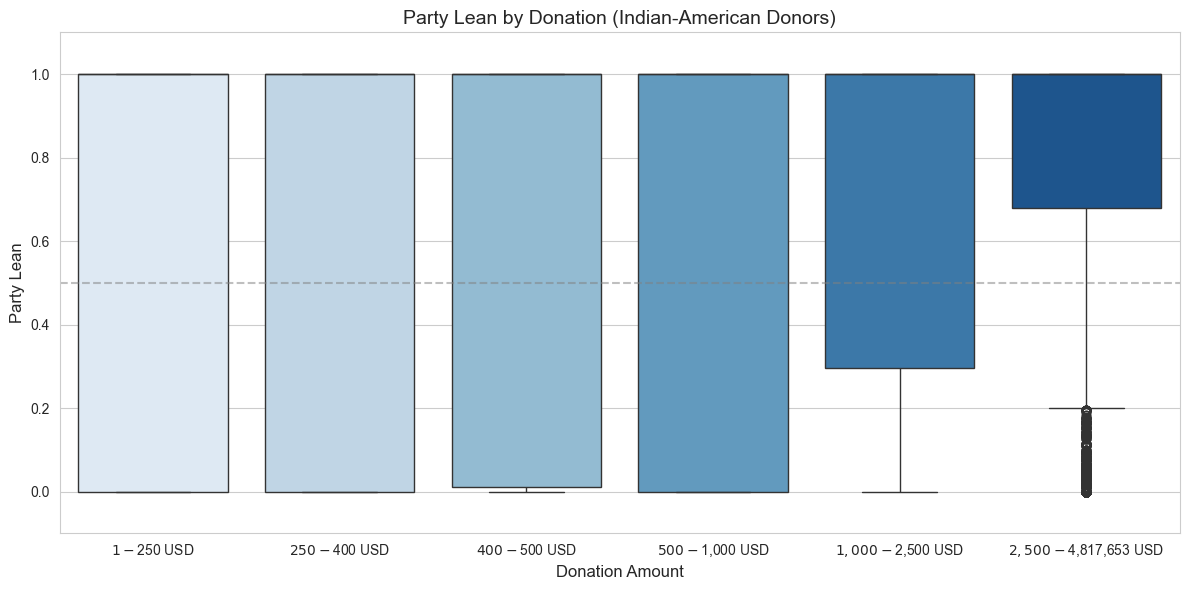

In [ ]:
all_donors["donation_bin"] = pd.qcut(
    all_donors[all_donors["ethnic"] == "ind"]["total_donated"],
    q=6,
    labels=False
)

bin_edges = pd.qcut(
    all_donors[all_donors["ethnic"] == "ind"]["total_donated"],
    q=6,
    retbins=True
)[1]
bin_labels = [f"${int(bin_edges[i]):,}-${int(bin_edges[i + 1]):,} USD" for i in range(len(bin_edges) - 1)]

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=all_donors[all_donors["ethnic"] == "ind"],
    x="donation_bin",
    y="dem_ratio",
    palette="Blues"
)

plt.title("Party Lean by Donation (Indian-American Donors)", fontsize=14)
plt.xlabel("Donation Amount", fontsize=12)
plt.ylabel("Party Lean", fontsize=12)
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, fontsize=10)
plt.ylim(-0.1, 1.1)
plt.axhline(0.5, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
grouped_stats = all_donors[all_donors["ethnic"] == "ind"].groupby("donation_bin")["dem_ratio"].agg(["mean", "median"])

# Add the bin labels for better readability
grouped_stats["donation_range"] = bin_labels

# Print the results
print(grouped_stats[["donation_range", "mean", "median"]])

                     donation_range      mean  median
donation_bin                                         
0.0                     $1-$250 USD  0.700559     1.0
1.0                   $250-$400 USD  0.678194     1.0
2.0                   $400-$500 USD  0.729620     1.0
3.0                 $500-$1,000 USD  0.722873     1.0
4.0               $1,000-$2,500 USD  0.734635     1.0
5.0           $2,500-$4,817,653 USD  0.758510     1.0


In [ ]:
# Group by donation_bin and calculate quartiles for dem_ratio
quartiles = all_donors[all_donors["ethnic"] == "ind"].groupby("donation_bin")["dem_ratio"].quantile([0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75]).unstack()

# Add the bin labels for better readability
quartiles["donation_range"] = bin_labels

# Rename columns for clarity
quartiles.columns = ["Range", "10th", "20th", "25th", "30th", "40th", "50th (Median)", "75th"]
quartiles

,Range,10th,20th,25th,30th,40th,50th (Median),75th
donation_bin,,,,,,,,
0.0,0.0,0.0,0.000000,0.500000,1.0,1.0,1.0,$1-$250 USD
1.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,$250-$400 USD
2.0,0.0,0.0,0.010941,1.000000,1.0,1.0,1.0,$400-$500 USD
3.0,0.0,0.0,0.000000,0.846154,1.0,1.0,1.0,"$500-$1,000 USD"
4.0,0.0,0.0,0.296774,0.931818,1.0,1.0,1.0,"$1,000-$2,500 USD"
5.0,0.0,0.0,0.678489,0.986188,1.0,1.0,1.0,"$2,500-$4,817,653 USD"
